In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def Warp(img,src,dst,inverse=False):
    img_size = (img.shape[1],img.shape[0])          
    M  = cv2.getPerspectiveTransform(src,dst)
    InvM = cv2.getPerspectiveTransform(dst,src)
    if inverse:
        warped = cv2.warpPerspective(img,InvM,img_size,flags=cv2.INTER_LINEAR)
    else:
        warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped

In [3]:
def Binary_gradient(img):
    hls =  cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,1]
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary

In [8]:
def Find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print("Fail to concatenate lane inds")

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [9]:
def fit_polynomial(binary_warped):
    x1,y1,x2,y2,_ = Find_lane_pixels(binary_warped)
    left_fit = np.polyfit(y1,x1,2)
    right_fit = np.polyfit(y2,x2,2)
    ploty = np.linspace(0,binary_warped.shape[0]-1,binary_warped.shape[0])
    try:
        left_lane = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_lane = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_lane = 1*ploty**2 + 1*ploty
        right_lane = 1*ploty**2 + 1*ploty
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img[y1, x1] = [255, 0, 0]
    out_img[y2, x2] = [0, 0, 255]
    
  #  plt.plot(left_lane,ploty,color="orange")
   # plt.plot(right_lane,ploty,color="orange")
    poly_parameter = {"out_img":out_img,"left_fit":left_fit,"right_fit":right_fit}
    return poly_parameter     

In [10]:
def drawLine(img, para,src,dst):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    left_fit,right_fit = para["left_fit"],para["right_fit"]
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
   
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
     #center of lane 
    center = (yMax//2)
    left_center_x,left_center_y =int(left_fitx[center]),int(center)
    right_center_x,right_center_y =int(right_fitx[center]),int(center)
   
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int_([pts_left]),False, (0,0, 255),30)
    cv2.polylines(color_warp, np.int_([pts_right]),False, (0,0,255),30)
    
    #center of both lane
    x_center,y_center = left_center_x + ((right_center_x - left_center_x)//2),center
    cv2.circle(color_warp,(x_center,y_center), 20, (255,255,0),-1)
    
    #draw lane center
    cv2.circle(color_warp,(left_center_x,left_center_y), 20, (255,0,0),-1)
    cv2.circle(color_warp,(right_center_x,right_center_y), 20, (255,0,0),-1)
    unwarp = color_warp
    #inverse warp
    newwarp = Warp(color_warp,src,dst,inverse=True)
    
    return (x_center,y_center),cv2.addWeighted(img, 1, newwarp, 0.7, 0),unwarp

(480, 640, 3)

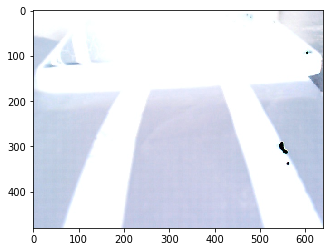

In [13]:
img = cv2.imread("img.jpg")
inv_img = abs(255-img)
plt.imshow(inv_img)
img.shape

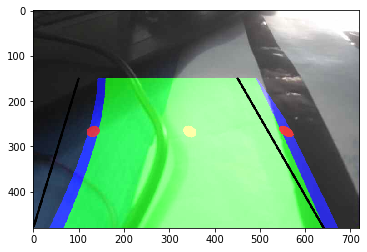

In [8]:
init_ = [[500,100],[640,480],[0,480],[130,100]] #[top_right,bottom_right,bottom_left,top_left] 
warp_ = [[640,0],[640,480],[0,480],[0,0]]      #[top_right,bottom_right,bottom_left,top_left]
 

init_ = [[450,150],[640,480],[0,480],[100,150]]
warp_ = [[640,0],[640,480],[0,480],[0,0]]
src = np.float32(init_)  #[top_right,bottom_right,bottom_left,top_left] 
dst = np.float32(warp_)        #[top_right,bottom_right,bottom_left,top_left]

warped = Warp(inv_img,src,dst)
binary_warped = Binary_gradient(warped)
poly_para = fit_polynomial(binary_warped)
lane_center,result,unwarp = drawLine(img,poly_para,src,dst) #pas original img

cv2.line(result,tuple(init_[0]),tuple(init_[1]),(0,0,0),3,cv2.LINE_AA)  #left
cv2.line(result,tuple(init_[2]),tuple(init_[3]),(0,0,0),3,cv2.LINE_AA)  #right

plt.imshow(result)

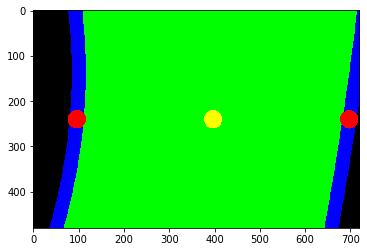

In [9]:
plt.imshow(unwarp)

# cap = cv2.VideoCapture("CarND-Advanced-Lane-Lines-P4-master/harder_challenge_video.mp4")
#cap = cv2.VideoCapture("CarND-Advanced-Lane-Lines-P4(For Refernce)/project_video.mp4")
#cap = cv2.VideoCapture("CarND-Advanced-Lane-Lines-P4-master/4.mp4")
cap = cv2.VideoCapture()

In [12]:
cap = cv2.VideoCapture(1)
init_ = [[920,190],[1500,415],[0,415],[600,190]]    #[top_right,bottom_right,bottom_left,top_left] 
warp_ = [[1300,0],[1500,415],[0,415],[200,0]]       #[top_right,bottom_right,bottom_left,top_left]
src = np.float32(init_) 
dst = np.float32(warp_)       

while True:
    ret,frame1 = cap.read()
    if ret:
        try:
            frame = frame1[280:800,:,:]
            frame = cv2.resize(frame,(1518,418))
            
            warped = Warp(frame,src,dst)
            binary_warped = Binary_gradient(warped)
            poly_para = fit_polynomial(binary_warped)
            
            lane_center,result,unwarp = drawLine(frame,poly_para,src,dst)
            car_center = (frame.shape[1]//2+25,frame.shape[0]//2+25)
            thresh_center = 60
            if lane_center[0] - car_center[0] > thresh_center:
                cv2.putText(result, 'right', (50,50), cv2.FONT_HERSHEY_SIMPLEX ,  2,(255,0,0), 2, cv2.LINE_AA) 
            if lane_center[0] - car_center[0] < thresh_center:
                cv2.putText(result, 'left', (50,50), cv2.FONT_HERSHEY_SIMPLEX ,  2, (255,0,0), 2, cv2.LINE_AA) 
                
            cv2.line(result,tuple(init_[0]),tuple(init_[1]),(0,0,0),3,cv2.LINE_AA)  #left
            cv2.line(result,tuple(init_[2]),tuple(init_[3]),(0,0,0),3,cv2.LINE_AA)  #right
            cv2.circle(result,car_center, 10, (0,0,0),-1)
            
            cv2.imshow("unwarp",unwarp)
            cv2.imshow("warped",warped)
            cv2.imshow("result",result)
            
            if cv2.waitKey(1) & 0xFF == 27:
                 break
        except:
            cv2.imshow("result",frame)
            cv2.imshow("warped",warped)
            if cv2.waitKey(1) & 0xFF == 27:
                 break
    else:
        break
cv2.destroyAllWindows()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib

In [12]:
cap = cv2.VideoCapture(1)
ret,frame1 = cap.read()
if ret:
    cv2.imwrite("img.jpg",frame1)
